# Analyzing the Spectrum of Explainability in Outcome-Oriented Predictive Process Monitoring

## BPIC2017_Accepted

### data preprocessing

#### importing libraries and terminology

In [1]:
#import libraries

In [2]:
import pandas as pd
import numpy as np
import time
import os
import random
import pickle
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tabulate import tabulate
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import FeatureUnion
import xgboost as xgb

In [3]:
#user specified packages from Teinemaa
from DatasetManager import DatasetManager

In [4]:
#tree packages
import graphviz
from sklearn import tree
from sklearn.preprocessing import OrdinalEncoder

#LSTM
import numpy as np
import pandas as pd
from pandas import Series
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import logging
plt.style.use('fivethirtyeight')

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import model_from_json

from collections import OrderedDict
from collections import defaultdict

import tensorflow.keras
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, Input, Reshape, Activation, Multiply, concatenate, Add,Embedding, LSTM, LayerNormalization
from tensorflow.keras.layers import Bidirectional, BatchNormalization, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow.keras.utils as ku


C:\Users\u0138175\Anaconda3\envs\aix360\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\u0138175\Anaconda3\envs\aix360\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\u0138175\Anaconda3\envs\aix360\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\u0138175\Anaconda3\envs\aix360\lib\site-packages\ten

Terminology

In [5]:
params_dir = './params_dir'
results_dir = './results' 
cls_encoding = 'agg'

gap = 1
n_iter = 1

bucket_encoding = "agg"

dataset_ref_to_datasets = {
    "bpic2011": ["bpic2011_f%s"%formula for formula in range(1,5)],
    "bpic2015": ["bpic2015_%s_f2"%(municipality) for municipality in range(1,6)],
    "insurance": ["insurance_activity", "insurance_followup"],
    "sepsis_cases": ["sepsis_cases_1", "sepsis_cases_2", "sepsis_cases_4"]
}

encoding_dict = {
    "laststate": ["static", "last"],
    "agg": ["static", "agg"],
    "index": ["static", "index"],
    "combined": ["static", "last", "agg"],
    "onehot": ["static", "onehot"]
}

In [6]:
#terminology

In [7]:
dataset_ref = 'bpic2017_accepted'

In [8]:
datasets = [dataset_ref] if dataset_ref not in dataset_ref_to_datasets else dataset_ref_to_datasets[dataset_ref]
methods = encoding_dict[cls_encoding]
    
train_ratio = 0.8
random_state = 22

In [9]:
# print dataset name

In [10]:
for dataset_name in datasets:
    print('Dataset:', dataset_name)

Dataset: bpic2017_accepted


In [11]:
# read the data

In [12]:
dataset_manager = DatasetManager(dataset_name)

In [13]:
data = dataset_manager.read_dataset()
cls_encoder_args = {'case_id_col': dataset_manager.case_id_col, 
                        'static_cat_cols': dataset_manager.static_cat_cols,
                        'static_num_cols': dataset_manager.static_num_cols, 
                        'dynamic_cat_cols': dataset_manager.dynamic_cat_cols,
                        'dynamic_num_cols': dataset_manager.dynamic_num_cols, 
                        'fillna': True}

In [14]:
#terminology

In [15]:
params_dir = './params_dir'
results_dir = './results' 
DT_dir = './DT_dir'
cls_encoding = 'agg'

gap = 1
n_iter = 1

dataset_ref_to_datasets = {
    "bpic2011": ["bpic2011_f%s"%formula for formula in range(1,5)],
    "bpic2015": ["bpic2015_%s_f2"%(municipality) for municipality in range(1,6)],
    "insurance": ["insurance_activity", "insurance_followup"],
    "sepsis_cases": ["sepsis_cases_1", "sepsis_cases_2", "sepsis_cases_4"]
}

encoding_dict = {
    "laststate": ["static", "last"],
    "agg": ["static", "agg"],
    "index": ["static", "index"],
    "combined": ["static", "last", "agg"],
    "onehot": ["static", "onehot"]
}

train_ratio = 0.8
random_state = 22

In [16]:
# determine min and max (truncated) prefix lengths

In [17]:
min_prefix_length = 1
if "traffic_fines" in dataset_name:
    max_prefix_length = 10
elif "bpic2017" in dataset_name:
    max_prefix_length = min(20, dataset_manager.get_pos_case_length_quantile(data, 0.90))
else:
    max_prefix_length = min(40, dataset_manager.get_pos_case_length_quantile(data, 0.90))

#### data preprocessing

In [18]:
# split into training and test
train, test = dataset_manager.split_data_strict(data, train_ratio, split="temporal")

In [19]:
#prefix generation of train and test data

In [20]:
print('prefixing started')
dt_train_prefixes = dataset_manager.generate_prefix_data(train, min_prefix_length, max_prefix_length)
dt_test_prefixes = dataset_manager.generate_prefix_data(test, min_prefix_length, max_prefix_length)

prefixing started


In [21]:
dt_train_prefixes_original = dt_train_prefixes.copy()
dt_test_prefixes_original = dt_test_prefixes.copy()

In [22]:
dt_test_prefixes.shape[0]

1303489

In [23]:
dt_test_prefixes.shape[1]

29

In [24]:
dt_test_prefixes.head()

,ApplicationType,LoanGoal,RequestedAmount,Case ID,label,Activity,org:resource,Action,EventOrigin,lifecycle:transition,...,timesincemidnight,event_nr,month,weekday,hour,open_cases,time:timestamp,case_length,prefix_nr,orig_case_id
958575,New credit,Unknown,0.0,Application_1985757094,regular,A_Create Application,User_41,Created,Application,complete,...,713.0,1.0,10.0,1.0,11.0,2270.0,2016-10-18 11:53:00.635,18,1,Application_1985757094
958593,New credit,Car,9500.0,Application_396092392,regular,A_Create Application,User_1,Created,Application,complete,...,719.0,1.0,10.0,1.0,11.0,2270.0,2016-10-18 11:59:27.616,20,1,Application_396092392
958619,New credit,Car,5000.0,Application_585529210,deviant,A_Create Application,User_1,Created,Application,complete,...,720.0,1.0,10.0,1.0,12.0,2271.0,2016-10-18 12:00:33.792,20,1,Application_585529210
958663,New credit,Car,25000.0,Application_1751900898,regular,A_Create Application,User_48,Created,Application,complete,...,722.0,1.0,10.0,1.0,12.0,2272.0,2016-10-18 12:02:09.032,20,1,Application_1751900898
958699,Limit raise,Car,15000.0,Application_867435788,deviant,A_Create Application,User_16,Created,Application,complete,...,725.0,1.0,10.0,1.0,12.0,2272.0,2016-10-18 12:05:35.074,20,1,Application_867435788


In [25]:
#get the label of the train and test set
test_y = dataset_manager.get_label_numeric(dt_test_prefixes)
train_y = dataset_manager.get_label_numeric(dt_train_prefixes)   

In [26]:
auc_totals = []
preds_all = []
test_y_all = []
nr_events_all = []
offline_total_times = []
online_event_times = []

In [27]:
nr_events_all.extend(list(dataset_manager.get_prefix_lengths(dt_test_prefixes)))  
test_y_all.extend(test_y)

### LSTM

In [28]:
#functions
def prepare_inputs(X_train, X_test, data):    
    oe = OrdinalEncoder()
    oe.fit(data)
    X_train_enc = oe.transform(X_train)
    X_test_enc = oe.transform(X_test)
    return X_train_enc, X_test_enc

def numeric_padding(sequences, maxlen=None, value=0):
    num_samples = len(sequences)
    sample_shape = np.asarray(sequences[0]).shape[1:]
    x = np.full((num_samples, maxlen) + sample_shape, value)
    for idx, s in enumerate(sequences):
        trunc = s[:maxlen]
        x[idx, :maxlen] = trunc[0]
        
def normalist(lst):
    s = sum(lst)
    norm = [float(i)/s for i in lst]
    return norm

    return x

def create_index(log_df, column):
    """Creates an idx for a categorical attribute.
    Args:
        log_df: dataframe.
        column: column name.
    Returns:
        index of a categorical attribute pairs.
    """
    temp_list = log_df[[column]].values.tolist()
    subsec_set = {(x[0]) for x in temp_list}
    subsec_set = sorted(list(subsec_set))
    alias = dict()
    for i, _ in enumerate(subsec_set):
        alias[subsec_set[i]] = i + 1
    return alias

#TRANSFORMATION

#categorical columns integercoded

dt_train_prefixes.dtypes

cat_columns = ['Activity', "Selected","ApplicationType",'Accepted','lifecycle:transition']

dt_train_prefixes[cat_columns],dt_test_prefixes[cat_columns]= prepare_inputs(dt_train_prefixes[cat_columns], dt_test_prefixes[cat_columns], data[cat_columns])

dt_train_prefixes[cat_columns] = dt_train_prefixes[cat_columns]+1

dt_test_prefixes[cat_columns] = dt_test_prefixes[cat_columns]+1

In [29]:
cat_columns.append('Case ID')
cat_columns.append('label')

cat_columns

ans_train = [pd.DataFrame(y) for x, y in dt_train_prefixes[cat_columns].groupby('Case ID', as_index=False)]
ans_test = [pd.DataFrame(y) for x, y in dt_test_prefixes[cat_columns].groupby('Case ID', as_index=False)]

train_labels = []
for i in range (0,len(ans_train)):
    temp_label = ans_train[i]['label'].iloc[0]
    train_labels.append(temp_label)

test_labels = []
for i in range (0,len(ans_test)):
    temp_label = ans_test[i]['label'].iloc[0]
    test_labels.append(temp_label)

train_y = [1 if i!='regular' else 0 for i in train_labels]
test_y = [1 if i!='regular' else 0 for i in test_labels]

cat_columns.remove('label')
cat_columns.remove('Case ID')

cat_columns

maxlen = cutoff =  max_prefix_length

In [30]:
maxlen

20

In [31]:
#cutoff: max amount of events in a prefix
no_activities= len(data.groupby(['Activity']))+1
no_loangoal = len(data.groupby(['LoanGoal']))+1
no_selected = len(data.groupby(['Selected']))+1
no_applicationtype = len(data.groupby(['ApplicationType']))+1
no_timesincelastevent= len(data.groupby(['timesincelastevent']))+1
no_accepted = len(data.groupby(['Accepted']))+1
no_lifecycle = len(data.groupby(['lifecycle:transition']))+1
embed_dim = 64

In [32]:
#padding of the different categorical columns
#train paddings
paddings_train = []
for i in cat_columns:
    padding= []
    for k in range(0,len(ans_train)):
        temp = []
        temp = list(ans_train[k][i])
        padding.append(temp)
    
    padded = np.array(pad_sequences(padding,maxlen=maxlen, padding='pre', truncating='pre',value=0))
    padded = padded/len(data.groupby([i]))
    paddings_train.append(padded)

#test paddings
paddings_test = []
for i in cat_columns:
    padding= []
    for k in range(0,len(ans_test)):
        temp = []
        temp = list(ans_test[k][i])
        padding.append(temp)
    
    padded = np.array(pad_sequences(padding,maxlen=maxlen, padding='pre', truncating='pre',value=0))
    padded = padded/len(data.groupby([i]))
    paddings_test.append(padded)

In [33]:
##### numerical columns
#NUMERICAL COLUMNS
numerical_columns = ['CreditScore',
'Case ID','timesincelastevent']

dt_train_prefixes2 = dt_train_prefixes[numerical_columns]
dt_test_prefixes2 = dt_test_prefixes[numerical_columns]

ans_train2 = [pd.DataFrame(y) for x,y in dt_train_prefixes2.groupby('Case ID', as_index=False)]
ans_test2 = [pd.DataFrame(y) for x,y in dt_test_prefixes2.groupby('Case ID', as_index=False)]

In [34]:
pad_train = []
pad_test  = []
num_columns = ['CreditScore','timesincelastevent']

for i in num_columns:
    padding = []
    for k in range(0,len(ans_train2)):
        temp_train = []
        temp_train = list(ans_train2[k][i])
        padding.append(temp_train)
        
    padded = np.array(pad_sequences(padding,maxlen=maxlen, padding='pre', truncating='pre',value=0))
    padded = padded/data[i].max()
    pad_train.append(padded)
for i in num_columns:
    padding = []
    for k in range(0,len(ans_test2)):
        temp_test = []
        temp_test = list(ans_test2[k][i])
        padding.append(temp_test)
        
    padded = np.array(pad_sequences(padding,maxlen=maxlen, padding='pre', truncating='pre',value=0))
    padded = padded/data[i].max()
    pad_test.append(padded)

#### tweede poging 2017

In [35]:
import os
import argparse
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import Sequence
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import non_neg, Constraint
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve


from tensorflow.keras.layers import Input, Concatenate, Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Nadam, Adam, SGD, Adagrad
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Bidirectional,TimeDistributed

, Multiply, Dropout

from tensorflow.keras.layers import GlobalAveragePooling1D

In [36]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Softmax, Lambda
from tensorflow.keras import backend

In [37]:
ac_index = create_index(dt_train_prefixes_original, 'Activity')
ac_index['Start'] = 0
ac_index['End'] = len(ac_index)
index_ac = {v: k for k, v in ac_index.items()}

s_index = create_index(dt_train_prefixes_original, 'Selected')
s_index['Start'] = 0
s_index['End'] = len(s_index)
index_s = {v: k for k, v in s_index.items()}

at_index = create_index(dt_train_prefixes_original, 'ApplicationType')
at_index['Start'] = 0
at_index['End'] = len(at_index)
index_at = {v: k for k, v in at_index.items()}

acc_index = create_index(dt_train_prefixes_original, 'Accepted')
acc_index['Start'] = 0
acc_index['End'] = len(acc_index)
index_acc = {v: k for k, v in acc_index.items()}

li_index = create_index(dt_train_prefixes_original, 'lifecycle:transition')
li_index['Start']  = 0
li_index['end'] = len(li_index)
index_li = {v: k for k, v in li_index.items()}

ac_weights = ku.to_categorical(sorted(index_ac.keys()), len(ac_index))
s_weights = ku.to_categorical(sorted(index_s.keys()), len(s_index))
at_weights = ku.to_categorical(sorted(index_at.keys()), len(at_index))
acc_weights = ku.to_categorical(sorted(index_acc.keys()), len(acc_index))
li_weights = ku.to_categorical(sorted(index_li.keys()), len(li_index))

In [38]:
dropout_input = 0.01
dropout_context=0.30
lstm_size_alpha=32
lstm_size_beta=32
print("Training prefix and variable attention model")

l2reg=0.001
allow_negative=False
incl_time = True 
incl_res = True
#Code Input
#categorical embeddings
input_layer_a = Input(shape=(cutoff,), name='activity_input')

input_layer_s = Input(shape=(cutoff,), name='selected_input')

input_layer_at = Input(shape=(cutoff,), name='applicationtype_input')

input_layer_acc = Input(shape=(cutoff,), name='accepted_input')

input_layer_li = Input(shape=(cutoff,), name='lifecycle_input')

time_input_layer = Input(shape=(cutoff,1), name='time_input')

input_layer_numeric = Input(shape=(cutoff,1), name='numeric_input')

########################################
#inputs_list = [ac_input]
   
#Calculate embedding for each code and sum them to a visit level
embedding_activity = Embedding(ac_weights.shape[0],
                            ac_weights.shape[1],
                            weights=[ac_weights],
                            input_length=no_activities,
                           name='ac_embedding')(input_layer_a)
dim =ac_weights.shape[1]

embedding_selected = Embedding(s_weights.shape[0],
                            s_weights.shape[1],
                            weights=[s_weights],
                            input_length=no_selected,
                             name='s_embedding')(input_layer_s)

dim += s_weights.shape[1]


embedding_applicationtype = Embedding(at_weights.shape[0],
                            at_weights.shape[1],
                            weights=[at_weights],
                            input_length=no_applicationtype,
                             name='at_embedding')(input_layer_at)
dim += at_weights.shape[1]

embedding_accepted = Embedding(acc_weights.shape[0],
                            acc_weights.shape[1],
                            weights=[acc_weights],
                            input_length=no_accepted,
                             name='acc_embedding')(input_layer_acc)

dim += acc_weights.shape[1]

embedding_lifecycle = Embedding(li_weights.shape[0],
                            li_weights.shape[1],
                            weights=[li_weights],
                            input_length=no_lifecycle,
                             name='li_embedding')(input_layer_li)

dim += li_weights.shape[1]

input_layer_numeric = Input(shape=(cutoff,1), name='numeric_input')

dim += 1

full_embs = concatenate([embedding_activity, embedding_selected, embedding_applicationtype, embedding_accepted, embedding_lifecycle, input_layer_numeric], name='catInp')

#Apply dropout on inputs
full_embs = Dropout(dropout_input)(full_embs)
time_embs = concatenate([full_embs, time_input_layer], name='allInp')

dim += 1

alpha = Bidirectional(LSTM(lstm_size_alpha, return_sequences=True),
                                    name='alpha')
beta = Bidirectional(LSTM(lstm_size_beta, return_sequences=True),
                                   name='beta')
alpha_dense = Dense(1, kernel_regularizer=l2(l2reg))
beta_dense = Dense(dim, activation='tanh', kernel_regularizer=l2(l2reg))

#Compute alpha, visit attention
alpha_out = alpha(time_embs)
alpha_out = TimeDistributed(alpha_dense, name='alpha_dense_0')(alpha_out)
alpha_out = Softmax(axis=1, name='alpha_softmax')(alpha_out)
#Compute beta, codes attention
beta_out = beta(time_embs)
beta_out = TimeDistributed(beta_dense, name='beta_dense_0')(beta_out)
#Compute context vector based on attentions and embeddings
c_t = Multiply()([alpha_out, beta_out, time_embs])
c_t = Lambda(lambda x: backend.sum(x, axis=1))(c_t)
        #Reshape to 3d vector for consistency between Many to Many and Many to One implementations
        #contexts = L.Lambda(reshape)(c_t)

#Make a prediction
contexts = Dropout(dropout_context)(c_t)
 
output_layer = Dense(1, activation='sigmoid', name='final_output')(contexts)

Training prefix and variable attention model
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [39]:
model = Model(inputs=[input_layer_a, input_layer_s, input_layer_at, input_layer_acc, input_layer_li, input_layer_numeric, time_input_layer], outputs=output_layer)

In [40]:
opt = Nadam(lr=0.0005, beta_1=0.9, beta_2=0.999,
                   epsilon=1e-08, schedule_decay=0.004, clipvalue=3)

model.compile(loss={'final_output':'binary_crossentropy'}, optimizer= opt)
    
model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
activity_input (InputLayer)     [(None, 20)]         0                                            
__________________________________________________________________________________________________
selected_input (InputLayer)     [(None, 20)]         0                                            
__________________________________________________________________________________________________
applicationtype_input (InputLay [(None, 20)]         0                                            
__________________________________________________________________________________________________
accepted_input (InputLayer)     [(None, 20)]         0                                            


In [41]:
output_file_path = os.path.join('./', 'models/model_rd_'+'_{epoch:02d}-{val_loss:.2f}.h5')

In [42]:
padded_time = np.reshape(pad_train[1], (len(pad_train[1]), cutoff, 1))
padded_time_test=  np.reshape(pad_test[1], (len(pad_test[1]), cutoff, 1))

pad_creditscore = np.reshape(pad_train[0], (len(pad_train[0]), cutoff, 1))
pad_creditscore_test = np.reshape(pad_test[0], (len(pad_test[0]), cutoff, 1))

model_checkpoint = ModelCheckpoint(output_file_path,
                                       monitor='val_loss',
                                       verbose=1,
                                       save_best_only=True,
                                       save_weights_only=False,
                                       mode='auto')

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

lr_reducer = ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.5,
                                   patience=10,
                                   verbose=0,
                                   mode='auto',
                                   min_delta=0.0001,
                                   cooldown=0,
                                   min_lr=0)
model_inputs = [paddings_train[0]]
model_inputs.append(paddings_train[1])
model_inputs.append(paddings_train[2])
model_inputs.append(paddings_train[3])
model_inputs.append(paddings_train[4])
model_inputs.append(pad_creditscore)
model_inputs.append(padded_time)

In [43]:
start = time.time()
model.fit(model_inputs,
              train_y,
              callbacks=[early_stopping, lr_reducer],
              validation_split = 0.1,
              verbose=1,
              epochs=10)
model_inputs_test = [paddings_test[0]]
model_inputs_test.append(paddings_test[1])
model_inputs_test.append(paddings_test[2])
model_inputs_test.append(paddings_test[3])
model_inputs_test.append(paddings_test[4])
model_inputs_test.append(pad_creditscore_test)
model_inputs_test.append(padded_time_test)
predictions = model.predict(model_inputs_test)
auc = roc_auc_score(test_y,predictions)
total_time = time.time() - start
print(total_time)
print(auc)

Train on 445402 samples, validate on 49490 samples
Epoch 1/10
445402/445402 [==============================] - 448s 1ms/sample - loss: 0.4160 - val_loss: 0.4050
Epoch 2/10
445402/445402 [==============================] - 445s 1ms/sample - loss: 0.4044 - val_loss: 0.4032
Epoch 3/10
445402/445402 [==============================] - 456s 1ms/sample - loss: 0.4027 - val_loss: 0.4016
Epoch 4/10
445402/445402 [==============================] - 457s 1ms/sample - loss: 0.4019 - val_loss: 0.4013
Epoch 5/10
445402/445402 [==============================] - 473s 1ms/sample - loss: 0.4011 - val_loss: 0.4001
Epoch 6/10
445402/445402 [==============================] - 501s 1ms/sample - loss: 0.4005 - val_loss: 0.3988
Epoch 7/10
445402/445402 [==============================] - 488s 1ms/sample - loss: 0.3994 - val_loss: 0.3991
Epoch 8/10
445402/445402 [==============================] - 477s 1ms/sample - loss: 0.3988 - val_loss: 0.3971
Epoch 9/10
445402/445402 [==============================] - 482s 1ms/

In [45]:
preds_list = predictions.tolist()
method_name = "attention"
cls_method = "LSTM"

In [46]:
preds_all = []
for i in preds_list:
    for j in i:
        preds_all.append(j)

In [47]:
if gap > 1:
    outfile = os.path.join(results_dir, "performance_results_%s_%s_%s_gap%s.csv" % (cls_method, dataset_name, method_name, gap))
else:
    outfile = os.path.join(results_dir, "performance_results_%s_%s_%s.csv" % (cls_method, dataset_name, method_name))

In [48]:
with open(outfile, 'w') as fout:
        fout.write("%s;%s;%s;%s;%s;%s\n"%("dataset", "method", "cls", "nr_events", "metric", "score"))
        fout.write("%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method,-1, "runtime_total", total_time))
        fout.write("%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method,-1, "runtime_avg", total_time/10))  
        dt_results = pd.DataFrame({"actual": test_y_all, "predicted": preds_all, "nr_events": nr_events_all})
        for nr_events, group in dt_results.groupby("nr_events"):
            if len(set(group.actual)) < 2:
                fout.write("%s;%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method, nr_events,-1, "auc", np.nan))
            else:
                fout.write("%s;%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method, nr_events,-1, "auc", roc_auc_score(group.actual, group.predicted)))
        fout.write("%s;%s;%s;%s;%s;%s\n"%(dataset_name, method_name, cls_method,-1, "auc", roc_auc_score(dt_results.actual, dt_results.predicted)))
        fout.write("%s\n"%(auc))

In [49]:
cat_columns

['Activity', 'Selected', 'ApplicationType', 'Accepted', 'lifecycle:transition']

In [50]:
#   Next event selection method and numbers of repetitions
#variants = [{'imp': 'Arg Max', 'rep': 1}]#,
               # {'imp': 'Random Choice', 'rep': 1}]
#   Generation of predictions
has_time=False
    #model = load_model(os.path.join(output_route, parameters['model_file']))
model = model
layer_names = [layer.name for layer in model.layers]
print(layer_names)
l_emb_weights=None
ac_emb_weights = model.get_layer(name='ac_embedding').get_weights()[0]

s_emb_weights = model.get_layer(name='s_embedding').get_weights()[0]
    
at_emb_weights = model.get_layer(name='at_embedding').get_weights()[0]  
    
acc_emb_weights = model.get_layer(name='acc_embedding').get_weights()[0]  
    
li_emb_weights = model.get_layer(name='li_embedding').get_weights()[0]  

has_time=True

ac_output_weights, ac_bias = model.get_layer(name='final_output').get_weights()
print(ac_output_weights)
model_with_attention = Model(model.inputs, model.outputs +\
                                              [model.get_layer(name='alpha_softmax').output,\
                                               model.get_layer(name='beta_dense_0').output])

['activity_input', 'selected_input', 'applicationtype_input', 'accepted_input', 'lifecycle_input', 'ac_embedding', 's_embedding', 'at_embedding', 'acc_embedding', 'li_embedding', 'numeric_input', 'catInp', 'dropout', 'time_input', 'allInp', 'alpha', 'alpha_dense_0', 'beta', 'alpha_softmax', 'beta_dense_0', 'multiply', 'lambda', 'dropout_1', 'final_output']
[[-6.3620913e-01]
 [-1.2251895e-04]
 [ 3.3691275e-01]
 [ 1.0946722e-01]
 [ 4.3062326e-02]
 [-2.2745208e-01]
 [ 1.2258184e+00]
 [-1.2330111e+00]
 [ 7.7601291e-02]
 [-1.2309680e+00]
 [ 6.3029730e-01]
 [-1.2841297e+00]
 [-1.3950717e+00]
 [ 1.3732404e+00]
 [ 1.2861905e+00]
 [-1.3066663e+00]
 [-1.2674085e+00]
 [ 1.8938418e-01]
 [ 1.3340439e+00]
 [ 6.4933650e-02]
 [ 6.8724602e-02]
 [ 2.1055220e-01]
 [ 1.3454434e+00]
 [ 2.7540168e-01]
 [ 8.4319919e-02]
 [ 2.7558023e-02]
 [ 1.3449121e+00]
 [-4.4926631e-01]
 [ 4.6169812e-06]
 [ 9.2923504e-01]
 [-2.5090665e-01]
 [ 1.0890564e+00]
 [-7.8355916e-02]
 [ 3.0549797e-01]
 [-8.8688874e-01]
 [ 1.035375

In [51]:
#original

In [52]:
temporal_vectors = []
variable_vectors=[]
predictions = []
for i in range(0,len(paddings_test[0])):
    x_ac_ngram = paddings_test[0][i].reshape((1,cutoff))
    x_s_ngram = paddings_test[1][i].reshape((1,cutoff))
    x_at_ngram = paddings_test[2][i].reshape((1,cutoff))
    x_acc_ngram = paddings_test[3][i].reshape((1,cutoff))
    x_li_ngram = paddings_test[4][i].reshape((1,cutoff))
    x_in_ngram  = pad_creditscore_test[i].reshape(1, cutoff, 1)
    x_t_ngram   = padded_time_test[i].reshape(1, cutoff, 1)
    betas=None      
    proba, alphas, betas = model_with_attention.predict([x_ac_ngram, x_s_ngram, x_at_ngram, x_acc_ngram, x_li_ngram, x_in_ngram,x_t_ngram])
    #print(proba, alphas, betas)
    proba = np.squeeze(proba)
    alphas = np.squeeze(alphas)
    temporal_att_vec = alphas
    assert (np.sum(temporal_att_vec) - 1.0) < 1e-5
    #print(temporal_att_vec)
    temporal_vectors.append(temporal_att_vec)

    if betas is not None:
        #get the beta value
        betas = np.squeeze(betas)
        idx = np.argmax(alphas)
        #print(idx)
        beta_val = betas[idx]
        # get the activity and role for that idx
        act_ip = int(x_ac_ngram[0][idx])
        ac_emb = ac_emb_weights[act_ip]
        dim=ac_emb.shape[0]
        
        rol_ip = int(x_s_ngram[0][idx])
        s_emb = s_emb_weights[rol_ip]
        dim += s_emb.shape[0]
            
       
        rol_ip = int(x_at_ngram[0][idx])
        at_emb = at_emb_weights[rol_ip]
        dim += at_emb.shape[0]
        
        
        rol_ip = int(x_acc_ngram[0][idx])
        acc_emb = acc_emb_weights[rol_ip]
        dim += acc_emb.shape[0]
           
        
        rol_ip = int(x_li_ngram[0][idx])
        li_emb = li_emb_weights[rol_ip]
        dim += li_emb.shape[0]
            
        num_v = np.squeeze(x_in_ngram)[idx]
        dim +=1
        
        if(betas.shape[1]==dim+1):
            time_v = np.squeeze(x_t_ngram)[idx]  # time and role as masked together
            emb = np.concatenate((ac_emb,s_emb,at_emb,acc_emb,li_emb,num_v,time_v), axis=None)
          
        #print('beta_val',beta_val.shape)
        beta_scaled = np.multiply(beta_val,emb)
        variable_attn = alphas[idx] * beta_scaled
        #sum_grad = np.sum(ac_output_weights, axis=1)
        #variable_attn=np.multiply(sum_grad.flatten(), variable_attn)
        variable_vectors.append(variable_attn)
        predictions.append(proba)

without correction

['Start', 'A_Accepted', 'A_Cancelled', 'A_Complete', 'A_Concept', 'A_Create Application', 'A_Denied', 'A_Incomplete', 'A_Pending', 'A_Submitted', 'A_Validating', 'O_Accepted', 'O_Cancelled', 'O_Create Offer', 'O_Created', 'O_Refused', 'O_Returned', 'O_Sent (mail and online)', 'O_Sent (online only)', 'W_Assess potential fraud', 'W_Call after offers', 'W_Call incomplete files', 'W_Complete application', 'W_Handle leads', 'W_Shortened completion ', 'W_Validate application', 'End']
['Start', 'False', 'True', 'missing', 'End']
['Start', 'Limit raise', 'New credit', 'End']
['Start', 'False', 'True', 'missing', 'End']
['Start', 'ate_abort', 'complete', 'resume', 'schedule', 'start', 'suspend', 'withdraw', 'end']
52
    attributes          attribute_values
0     0.007563                     Start
1     0.000033                A_Accepted
2     0.004139               A_Cancelled
3     0.005151                A_Complete
4     0.001201                 A_Concept
5    -0.006106      A_Create Applica

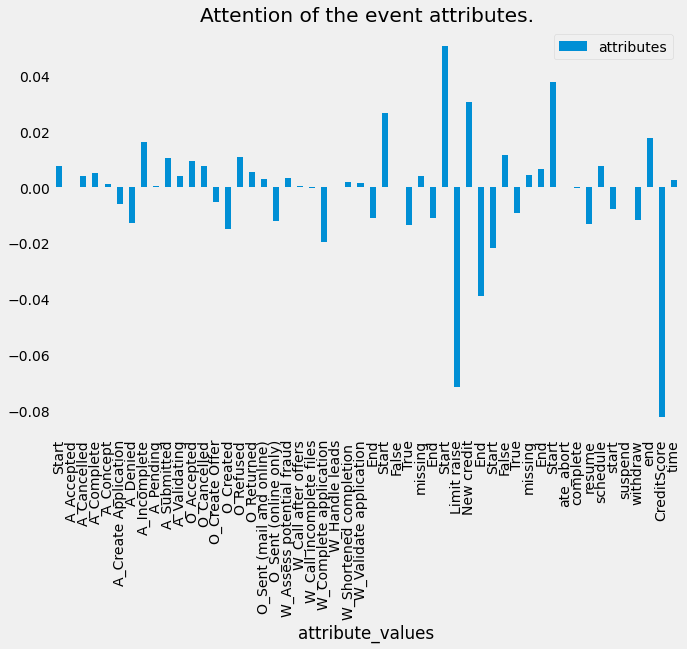

In [53]:
if(len(variable_vectors)>0):
    var_final = np.mean(np.array(variable_vectors), axis=0)
    ac_labels = [index_ac[key] for key in sorted(index_ac.keys())]
    s_labels = [index_s[key] for key in sorted(index_s.keys())]
    at_labels = [index_at[key] for key in sorted(index_at.keys())]
    acc_labels = [index_acc[key] for key in sorted(index_acc.keys())]
    li_labels = [index_li[key] for key in sorted(index_li.keys())]
    print(ac_labels)
    print(s_labels)
    print(at_labels)
    print(acc_labels)
    print(li_labels)
      
    num_dim = var_final.shape[0]
    print(num_dim)
      
    if s_emb_weights is not None:
        ac_labels.extend(s_labels)
    if at_emb_weights is not None:
        ac_labels.extend(at_labels)  
    if acc_emb_weights is not None:
        ac_labels.extend(acc_labels)
    if li_emb_weights is not None:
        ac_labels.extend(li_labels)
    ac_labels.append('CreditScore')
    ac_labels.append('time')
        
    df_var=pd.DataFrame({'attributes':var_final, 'attribute_values':ac_labels})
    print(df_var)
    df_var.plot.bar(y='attributes', x='attribute_values',
                                title='Attention of the event attributes.', figsize=(10,7))
                                                                               
    #plot_history( plt, file_name + 'variable_attn', path )
      

    # Hide grid lines
    plt.grid(False)
    plt.show()

#### parsimony

In [59]:
parsimony = 0
for i in range(0,len(df_var['attributes'])):
    if df_var['attributes'][i]>0:
        parsimony = parsimony+1
parsimony

31

In [60]:
len(df_var['attributes'])

52

#### Functional complexity

In [62]:
def functional_complexity(n_instances):
    NF=0
    #categorical_columns
    list_of_random_instances = list(np.random.permutation(np.arange(0,n_instances))[:n_instances])
    for j in range(0,len(paddings_test)):
        for i in list_of_random_instances:
            new_paddings_test = paddings_test.copy()
            #new prediction after permutation 
            new_paddings_test[j][i] = random.uniform(0,1)
            #new_paddings_test[j][i] = np.random.permutation(new_paddings_test[j][i])
            new_model_inputs_test = [[np.array(new_paddings_test[0][i])]]
            new_model_inputs_test.append([np.array(new_paddings_test[1][i])])
            new_model_inputs_test.append([np.array(new_paddings_test[2][i])])
            new_model_inputs_test.append([np.array(new_paddings_test[3][i])])
            new_model_inputs_test.append([np.array(new_paddings_test[4][i])])
            new_model_inputs_test.append([np.array(pad_creditscore_test[i])])
            new_model_inputs_test.append([np.array(padded_time_test[i])])
            pred2 = model.predict(new_model_inputs_test)
            pred2= np.round(pred2)
            #prediction without permutation
            model_inputs_test = [[np.array(paddings_test[0][i])]]
            model_inputs_test.append([np.array(paddings_test[1][i])])
            model_inputs_test.append([np.array(paddings_test[2][i])])
            model_inputs_test.append([np.array(paddings_test[3][i])])
            model_inputs_test.append([np.array(paddings_test[4][i])])
            model_inputs_test.append([np.array(pad_creditscore_test[i])])
            model_inputs_test.append([np.array(padded_time_test[i])])
            pred1 = model.predict(model_inputs_test)
            pred1 = np.round(pred1)
            
            if pred1 == pred2:
                NF = NF+1
    #numerical
    list_of_sets=[]
    set_of_values = set()
    #the different values of each column in a set
    #all these sets are added to the list_of_sets list        
    for j in range(0,len(num_columns)):
        set_of_values = set(dt_test_prefixes[num_columns[j]])
        for i in list_of_random_instances:
            new_pad_test = pad_test.copy()
            new_pad_test[j][i] = random.choice(list(set_of_values))
           
            new_padded_time_test=  np.reshape(new_pad_test[1], (len(new_pad_test[1]), cutoff, 1))
            new_pad_creditscore_test = np.reshape(new_pad_test[0], (len(new_pad_test[0]), cutoff, 1))
            #new prediction after permutation
           
            new_model_inputs_test = [[np.array(paddings_test[0][i])]]
            new_model_inputs_test.append([np.array(paddings_test[1][i])])
            new_model_inputs_test.append([np.array(paddings_test[2][i])])
            new_model_inputs_test.append([np.array(paddings_test[3][i])])
            new_model_inputs_test.append([np.array(paddings_test[4][i])])
            new_model_inputs_test.append([np.array(new_pad_creditscore_test[i])])
            new_model_inputs_test.append([np.array(new_padded_time_test[i])])
            pred2 = model.predict(new_model_inputs_test)
            pred2= np.round(pred2)
            #prediction without permutation
            model_inputs_test = [[np.array(paddings_test[0][i])]]
            model_inputs_test.append([np.array(paddings_test[1][i])])
            model_inputs_test.append([np.array(paddings_test[2][i])])
            model_inputs_test.append([np.array(paddings_test[3][i])])
            model_inputs_test.append([np.array(paddings_test[4][i])])
            model_inputs_test.append([np.array(pad_creditscore_test[i])])
            model_inputs_test.append([np.array(padded_time_test[i])])
            pred1 = model.predict(model_inputs_test)
            pred1 = np.round(pred1)
            
            if pred1 == pred2:
                NF = NF+1           
                
    
    return NF

In [63]:
functional_complexity(500)

3500

In [65]:
31*500

15500

In [64]:
52*500

26000

#### Monotonicity

##### perturbation importance

In [134]:
numbers = [no_activities, no_selected,no_applicationtype,no_accepted,no_lifecycle,1,1]

numbers

sample_length = 50000
effects_saved = []
def data_sample(model_inputs):
    sample_data = []
    for i in range(0, len(model_inputs)):
        sample_data.append(model_inputs[i][0:sample_length])
    return sample_data
def var_importance(model, model_inputs):
    x = data_sample(model_inputs)
    orig_out = model.predict(x)
    for i in range(0,len(cat_columns)):  # iterate over the 5 cat features
        print(i)
        new_x = x.copy()
        perturbations_list = []
        for j in range(0,sample_length):
            prefix_array = np.random.random((maxlen,))
            perturbations_list.append(prefix_array)
        new_x[i] = np.array(perturbations_list)
        perturbed_out = model.predict(new_x)
        effect = (((orig_out - perturbed_out) ** 2)/20).mean() ** 0.5
        print(f'Variable {i+1}, perturbation effect: {effect:.4f}')
        effects_saved.append(effect)
    for k in range(i+1,len(model_inputs)):  # iterate over the 2 num features
        print(k)
        new_x = x.copy()
        perturbations_list = []
        for j in range(0,sample_length):
            prefix_array = np.random.random((maxlen,))
            perturbations_list.append(prefix_array)
        perturbation_array = np.array(perturbations_list)
        perturbations_reshaped = perturbation_array.reshape(sample_length, cutoff, 1)
        new_x[k] = perturbations_reshaped
        perturbed_out = model.predict(new_x)
        effect = (((orig_out - perturbed_out) ** 2)/20).mean() ** 0.5
        print(f'Variable {(k+1)}, perturbation effect: {effect:.4f}')    
        effects_saved.append(effect)

var_importance(model, model_inputs_test)

0
Variable 1, perturbation effect: 0.0063
1
Variable 2, perturbation effect: 0.0175
2
Variable 3, perturbation effect: 0.0772
3
Variable 4, perturbation effect: 0.0163
4
Variable 5, perturbation effect: 0.0085
5
Variable 6, perturbation effect: 0.1126
6
Variable 7, perturbation effect: 0.1153


##### attention values

In [95]:
cat_columns = ['Activity', "Selected","ApplicationType",'Accepted','lifecycle:transition']

In [96]:
attention_values = []

In [97]:
#activity

In [98]:
len([index_ac[key] for key in sorted(index_ac.keys())])

27

In [99]:
abs(df_var['attributes'].iloc[0:27]).sum(skipna = True)

0.17477357

In [100]:
attention_values.append(0.17477357)

In [101]:
#selected

In [102]:
len(s_labels)

5

In [103]:
abs(df_var['attributes'].iloc[27:32]).sum(skipna = True)

0.05501943

In [104]:
attention_values.append(0.05501943)

In [105]:
#at_labels

In [106]:
len(at_labels)

4

In [107]:
abs(df_var['attributes'].iloc[32:36]).sum(skipna = True)

0.19171786

In [108]:
attention_values.append(0.19171786)

In [109]:
len(acc_labels)

5

In [110]:
abs(df_var['attributes'].iloc[36:41]).sum(skipna = True)

0.053377185

In [111]:
attention_values.append(0.053377185)

In [112]:
len(li_labels)

9

In [113]:
abs(df_var['attributes'].iloc[41:50]).sum(skipna = True)

0.096021466

In [114]:
abs(df_var['attributes'].iloc[50:51]).sum(skipna = True)

0.08241622

In [115]:
abs(df_var['attributes'].iloc[51:52]).sum(skipna = True)

0.0026337507

In [116]:
attention_values.append(0.096021466)
attention_values.append(0.08241622)
attention_values.append(0.0026337507)

In [118]:
attention_values

[0.17477357,
 0.05501943,
 0.19171786,
 0.053377185,
 0.096021466,
 0.08241622,
 0.0026337507]

In [120]:
courses =  ['Activity', "Selected","ApplicationType",'Accepted','lifecycle:transition','CreditScore', 'timesincelastevent']

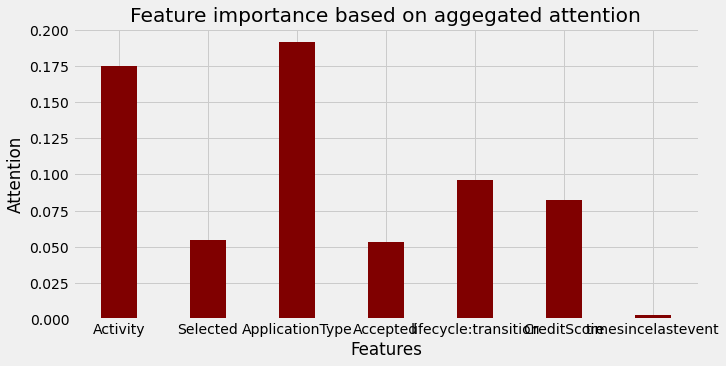

In [121]:
values=attention_values
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='maroon',
        width = 0.4)
 
plt.xlabel("Features")
plt.ylabel("Attention")
plt.title("Feature importance based on aggegated attention")
plt.show()

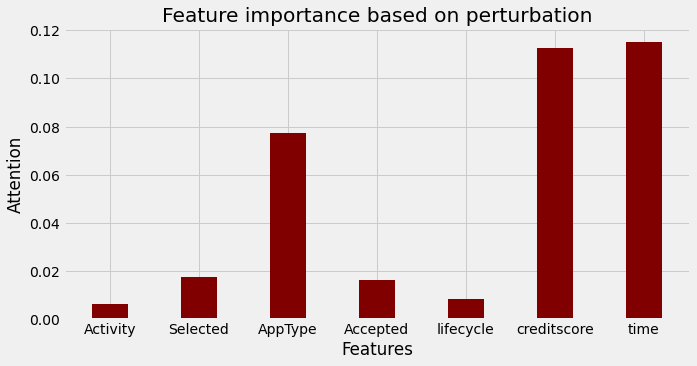

[0.006325350425147733,
 0.017464189867900513,
 0.07720002127837657,
 0.0162694213237804,
 0.008498458046907157,
 0.11258674942617489,
 0.11529009086329643]

In [135]:
courses = ['Activity', 'Selected','AppType','Accepted', 'lifecycle', 'creditscore', 'time']
values = effects_saved
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='maroon',
        width = 0.4)
 
plt.xlabel("Features")
plt.ylabel("Attention")
plt.title("Feature importance based on perturbation")
plt.show()

effects_saved

In [136]:
from scipy.stats import kendalltau

coef, p = kendalltau(effects_saved, attention_values)
print('Kendall correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)

from scipy.stats import spearmanr
# seed random number generator

Kendall correlation coefficient: -0.333
Samples are uncorrelated (fail to reject H0) p=0.381


In [137]:
# prepare data

coef, p = spearmanr(attention_values, effects_saved)
print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
	print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
	print('Samples are correlated (reject H0) p=%.3f' % p)

Spearmans correlation coefficient: -0.429
Samples are uncorrelated (fail to reject H0) p=0.337
